### Old Functions used from Assignment 1

In [123]:
import numpy as np
import math
from scipy import fft
from scipy.interpolate import interp1d
from scipy.linalg import eig
import matplotlib.pyplot as plt

def RK4(f, current_state: tuple, step_size: float = 0.01) -> float:
    """Performs Runge-Kunta 4th Order for a Single Step

    Args:
        f (_type_): A function.
        current_state (tuple): Inputs to the functions applicable
        step_size (float, optional): The step size used in RK4. Defaults to 0.01.

    Returns:
        float: A new value, f(current_state+step_size)
    """    
    k1 = step_size * f(*current_state)

    k2 = step_size * f(
        *[current_state[i] + k1 * 0.5 for i in range(len(current_state))]
    )
    k3 = step_size * f(
        *[current_state[i] + k2 * 0.5 for i in range(len(current_state))]
    )
    k4 = step_size * f(*[current_state[i] + k3 for i in range(len(current_state))])

    return (k1 + 2 * k2 + 2 * k3 + k4) / 6

class SIRbase:
    def __init__(self, beta: float, gamma: float, I0: float):
        """
        Initialize base SIR model with model parameters (beta, gamma) and initial conditions (I(0))
        """
        self.beta = beta
        self.gamma = gamma

        self.S = 1 - I0
        self.I = I0
        self.R = 0

    def dSdt(self, S, I) -> float:
        """
        Differential equation for susceptible population.
        """
        return -self.beta * S * I

    def dIdt(self, S, I) -> float:
        """
        Differential equation for infected population.
        """
        return self.beta * S * I - self.gamma * I

    def update_step(self, dt=0.01):
        """
        Perform step update using the Runge–Kutta method as implemented prior
        """

        delta_S = RK4(self.dSdt, (self.S, self.I), step_size=dt)
        delta_I = RK4(self.dIdt, (self.S, self.I), step_size=dt)
        
        self.S += delta_S
        self.I += delta_I

        self.R = 1 - self.S - self.I

    def numerical_integration(self, t: int, dt: float = 0.01):
        """Numerical Integration of the SIR model over time t using RK4 with step size dt.

        Args:
            t (int): Total time.
            dt (float, optional): Step size for RK4. Defaults to 0.01.

        Returns:
            Matrix of t, S, I, R

        """
        times = np.linspace(0, t, int(t / dt) + 1)
        S_values = [self.S]
        I_values = [self.I]
        R_values = [self.R]

        for _ in times[1:]:
            self.update_step(dt)
            S_values.append(self.S)
            I_values.append(self.I)
            R_values.append(self.R)

        return np.column_stack((times, S_values, I_values, R_values)).T
    
class SIRdemography(SIRbase):
    def __init__(self, beta: float, gamma: float, I0: float, mu: float):
        """
        Initialize SIR model with demography parameters
        """
        super().__init__(beta, gamma, I0)
        self.mu = mu

    def dSdt(self, S, I):
        """
        Differential equation for susceptible population including demography.
        """
        return self.mu - self.beta * S * I - self.mu * S

    def dIdt(self, S, I):
        """
        Differential equation for infected population including demography.
        """
        return self.beta * S * I - I * self.gamma - I*self.mu
    
    def dRdt(self, I, R):
        return self.gamma * I - self.mu * R

    def update_step(self, dt=0.01):
        """
        Perform step update using the Runge–Kutta method, including infection-induced mortality.
        """

        delta_S = RK4(self.dSdt, (self.S, self.I), step_size=dt)
        delta_I = RK4(self.dIdt, (self.S, self.I), step_size=dt)
        delta_R = RK4(self.dRdt, (self.I, self.R), step_size=dt)
        
        self.S += delta_S
        self.I += delta_I
        self.R += delta_R

def compute_period_oscillations(beta, gamma, mu):
    """
    Compute the period of oscillations for the endemic equilibrium.

    Parameters:
    - beta: Infection rate
    - gamma: Recovery rate
    - mu: Birth/death rate

    Returns:
    - The period of oscillations.
    """
    reproductive_number = beta / (gamma + mu)
    
    # Compute parameters for oscillation period formula
    A = 1 / (mu * (reproductive_number - 1))
    G = 1 / (mu + gamma)
    
    # Return the oscillation period
    return 1 / (2 * math.pi * np.sqrt(A * G))


def decay_rate(beta, gamma, mu):
    """
    Compute the decay rate of oscillations in the system.

    Parameters:
    - beta: Infection rate
    - gamma: Recovery rate
    - mu: Birth/death rate

    Returns:
    - Decay rate.
    """
    reproductive_number = beta / (gamma + mu)
    
    # Return the decay rate
    return -(mu * reproductive_number / 2)

def eigenvalue_analysis(beta, gamma, mu):
    """
    Perform an eigenvalue analysis to assess the stability of the endemic equilibrium.

    Parameters:
    - beta: Infection rate
    - gamma: Recovery rate
    - mu: Birth/death rate
    
    Raises:
    - ValueError: If the reproductive number (R0) is less than or equal to 1.
    """
    reproductive_number = beta / (gamma + mu)

    # Ensure R0 > 1 for an endemic equilibrium
    if reproductive_number <= 1:
        raise ValueError("R0 must be greater than 1 for an endemic equilibrium.")
    
    # Calculate endemic equilibrium points
    S_equil = (gamma + mu) / beta
    I_equil = (mu / beta) * (reproductive_number - 1)

    # Construct the Jacobian matrix at the endemic equilibrium
    J = np.array([[-beta * I_equil - mu, -beta * S_equil],
                  [beta * I_equil, beta * S_equil - (gamma + mu)]])

    # Compute the eigenvalues of the Jacobian matrix
    eigenvalues, _ = eig(J)
    #print(f"Eigenvalues of the Jacobian: {eigenvalues}")
    
    # Check stability based on the real parts of the eigenvalues
    #if np.all(np.real(eigenvalues) < 0):
    #    print("The endemic equilibrium is stable.")
    #else:
    #    print("The endemic equilibrium is not stable.")

    # Check for damped oscillations based on the imaginary parts of the eigenvalues
    #if np.any(np.imag(eigenvalues) != 0):
    #    print(f"The system approaches the endemic equilibrium (S: {S_equil}, I: {I_equil}) with damped oscillations.")
    #    print(f"The system has an oscillation period of {compute_period_oscillations(beta, gamma, mu)} and decay rate of {decay_rate(beta, gamma, mu)}")
    #else:
    #    print(f"The system approaches the endemic equilibrium (S: {S_equil}, I: {I_equil}) without oscillations.")

    return [{S_equil, I_equil}, compute_period_oscillations(beta,gamma,mu), decay_rate(beta,gamma,mu)]

### Implementation of Gillespie’s First Reaction Method

In [2]:
class GillespieFirstReaction:
    def __init__(self, discrete_event_model: dict, initial_state, model_parameters: dict):
        # Model Initialization for Algorithm
        self.model = discrete_event_model
        self.state = initial_state
        self.N = np.sum(initial_state)
        self.model_parameters = model_parameters

        # Track Evolution of Algorithm
        self.day = 0  
        self.times = [self.day]  
        self.history = [list(initial_state)]  

    def update_rates(self):
        # Unpack state and use
        S, I, R = self.state

        rates = {}
        for event, (rate, effect) in self.model.items():
            rates[event] = rate(S, I, R, self.N, **self.model_parameters)
        
        return rates
    
    def step(self):
        rates = self.update_rates()

        u = np.random.uniform(0, 1, size=len(rates))
        delta_t = -np.log(u) / np.array(list(rates.values()))

        min_index = np.argmin(delta_t)
        event = list(rates.keys())[min_index]

        self.day += delta_t[min_index]

        effect = self.model[event][1]
        self.state = [x + dx for x, dx in zip(self.state, effect)]

        # Store the results
        self.times.append(self.day)
        self.history.append(list(self.state))

    def run(self, max_days=100):
        while self.day < max_days:
            self.step()

        # Return time and history for plotting or further analysis
        return self.times, self.history
    

In [136]:
def multiple_runs(discrete_model, init_state, model_parameters, num_simulations, max_days, steps):
    # Wraps the above function to perform multiple simulations
    common_times = np.linspace(0, max_days, steps)

    final_S = []
    final_I = []

    for simulation in range(num_simulations):
        model = GillespieFirstReaction(discrete_model, init_state, model_parameters)
        times, history = model.run(max_days=max_days)
        # Store all interpolated S, I values from each simulation
        interpolated_S_values = []
        interpolated_I_values = []

        interp_func = interp1d(times, [state[1] for state in history] , bounds_error=False, fill_value="extrapolate")
        interpolated_I = interp_func(common_times)
        interpolated_I_values.append(interpolated_I)

        interp_func = interp1d(times, [state[0] for state in history] , bounds_error=False, fill_value="extrapolate")
        interpolated_S = interp_func(common_times)
        interpolated_S_values.append(interpolated_S)
        
        final_S.append(interpolated_S_values)
        final_I.append(interpolated_I_values)
    
    return np.array(common_times), np.array(final_S), np.array(final_I)
    

In [137]:
# Store the SIR model as a dictionary (Event: Rate, Effect)
SIR_model = {
    "E_b": (lambda S, I, R, N, beta, gamma, mu: mu * N, [1, 0, 0]),                     
    "E_t": (lambda S, I, R, N, beta, gamma, mu: beta * (S * I / N), [-1, 1, 0]),  
    "E_r": (lambda S, I, R, N, beta, gamma, mu: gamma * I, [0, -1, 1]),                 
    "E_dX": (lambda S, I, R, N, beta, gamma, mu: mu * S, [-1, 0, 0]),                   
    "E_dY": (lambda S, I, R, N, beta, gamma, mu: mu * I, [0, -1, 0]),                   
    "E_dR": (lambda S, I, R, N, beta, gamma, mu: mu * R, [0, 0, -1])                    
}

SIR_state = [990, 10, 0]
SIR_params = {
    'beta': 1,  
    'gamma': 0.3,  
    'mu': 1/20 
}

time_stoch, S_stoch, I_stoch = multiple_runs(SIR_model, SIR_state,SIR_params, 50, 200, 500)

C:\Users\NaniComputationalSci\AppData\Local\Temp\ipykernel_15756\3999031418.py:28: RuntimeWarning: divide by zero encountered in divide
  delta_t = -np.log(u) / np.array(list(rates.values()))


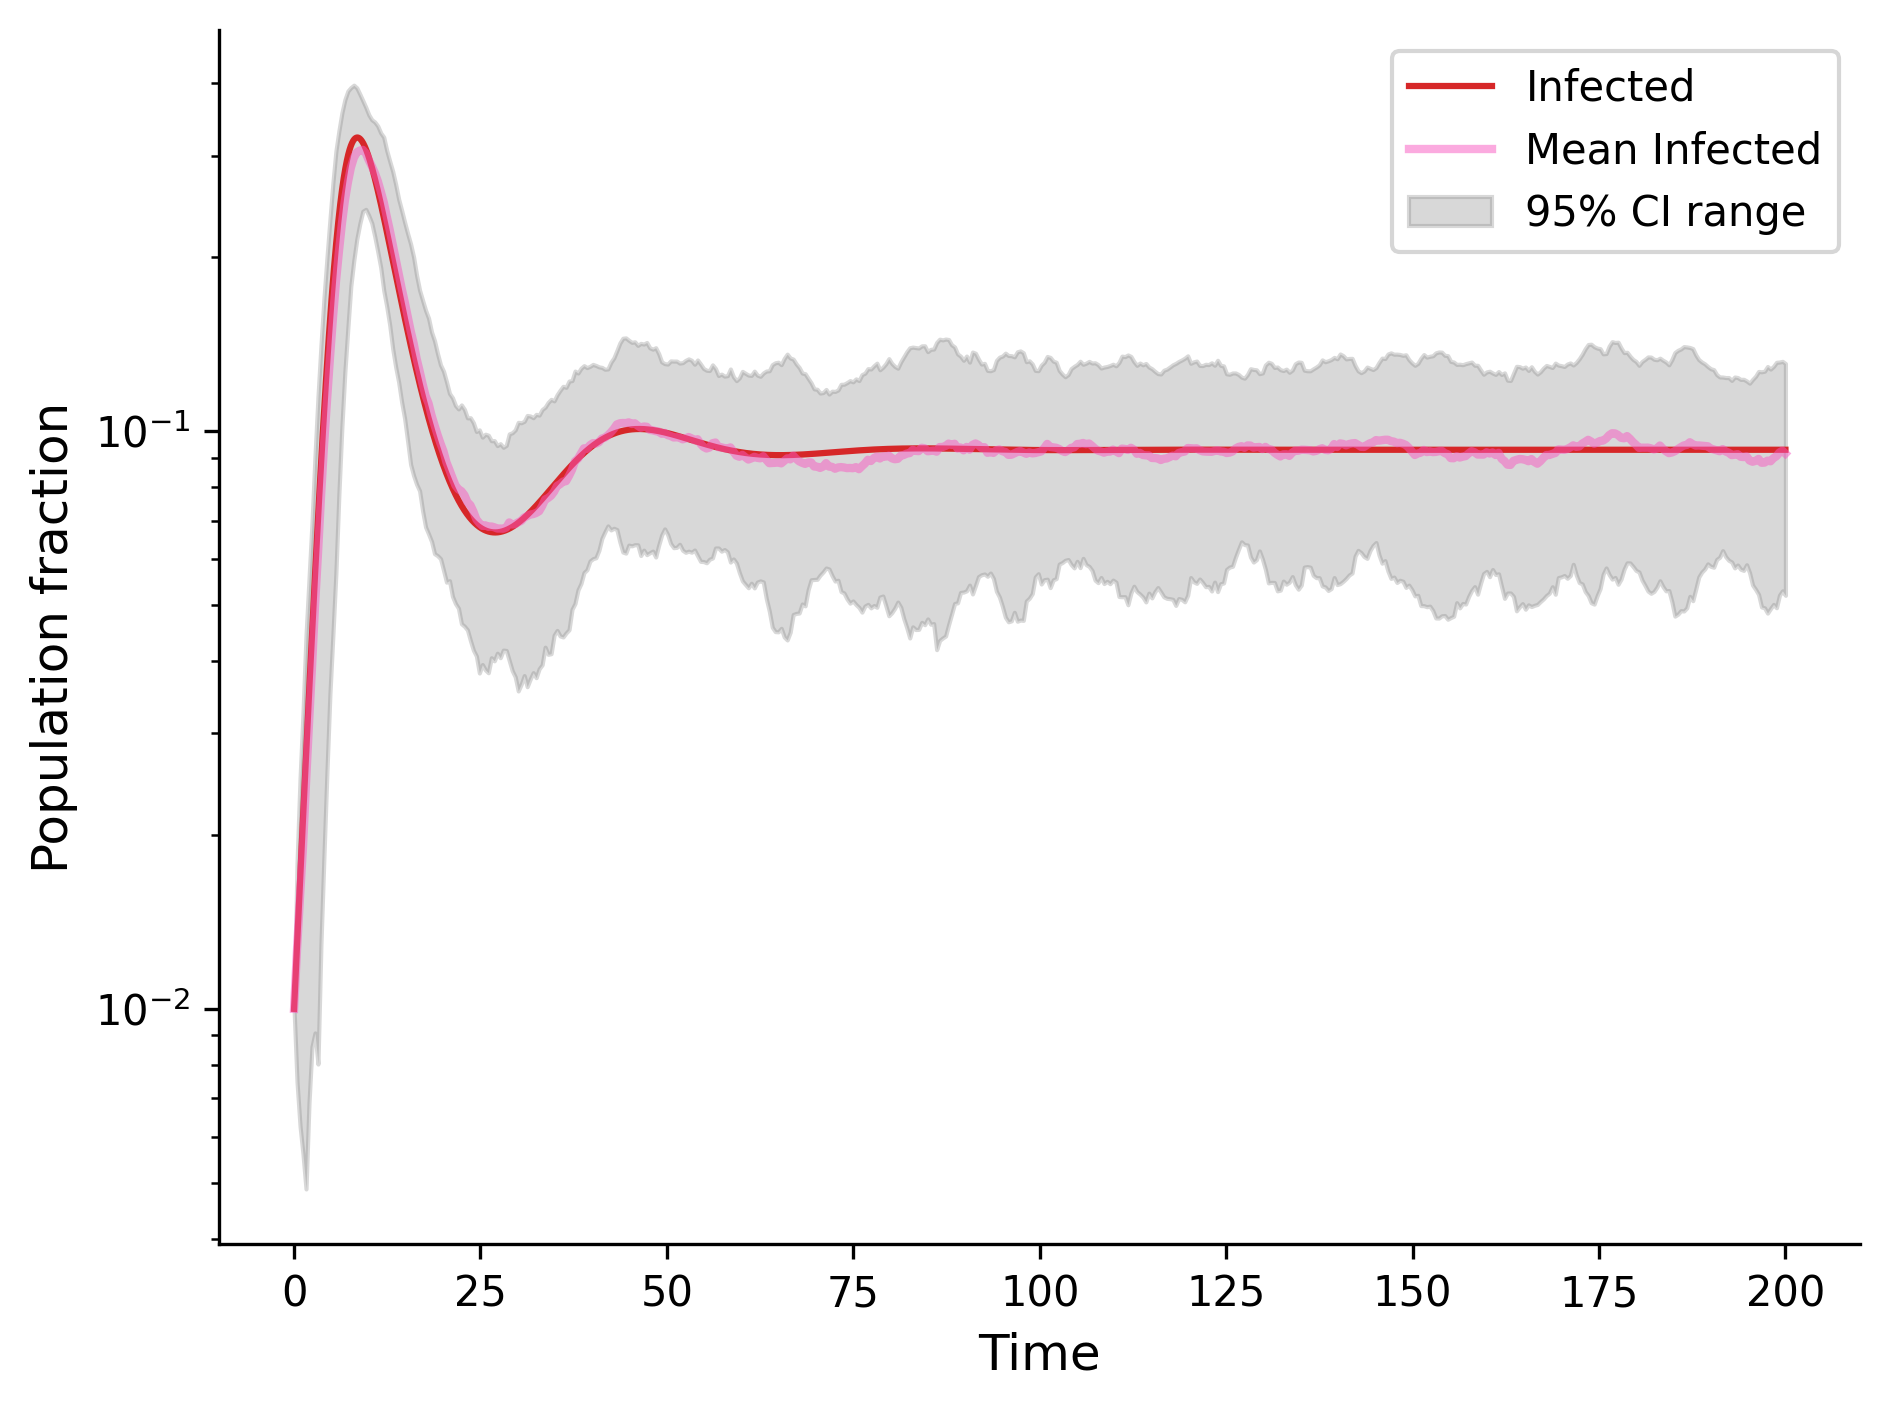

In [116]:
# Parameters
beta = 1
gamma = 0.3
mu = 1 / 20

# Color scheme
colors = {
    'Susceptible': '#ffbe30',
    'Exposed': '#fbcc98',
    'Infected': '#d62728',
    'Recovered': '#f857c1'
}

# Simulation settings
endemic_t = 200
endemic_dt = 0.005

# Run the demographic SIR model
t, S, I, R = SIRdemography(beta, gamma, 0.01, mu).numerical_integration(t=endemic_t, dt=endemic_dt)

# Calculate mean and standard deviation from stochastic simulations
mean_I = np.mean(I_stoch, axis=0)
std_I = np.std(I_stoch, axis=0)

# Plotting
plt.figure(dpi=300)

# Plot deterministic infected population
plt.plot(t, I, color=colors['Infected'], label='Infected')

# Plot the mean infected curve from stochastic simulations
plt.plot(time_stoch, mean_I[0] / 1000, color=colors['Recovered'], lw=2, alpha=0.5, label='Mean Infected')

# Plot the 95% confidence interval
plt.fill_between(
    time_stoch,
    (mean_I[0] - 1.96 * std_I[0]) / 1000,
    (mean_I[0] + 1.96 * std_I[0]) / 1000,
    color='gray', alpha=0.3, label='95% CI range'
)

# Axis labels and scaling
plt.xlabel('Time', fontsize=12)
plt.ylabel('Population fraction', fontsize=12)
plt.yscale('log')

# Remove top and right spines for cleaner look
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Display legend and finalize plot
plt.legend()
plt.tight_layout()
plt.show()


In [119]:
def SASIR(model_parameters, init_state, num_simulation, max_days):
    combinations = []
    constant_params = {key: value for key, value in model_parameters.items() if not isinstance(value, np.ndarray)}
    varrying_param = [key for key, value in model_parameters.items() if key not in constant_params][0]
    varying_values = model_parameters[varrying_param] 



    all_combinations_variances = []
    all_combinations_covariances = []

    for value in model_parameters[varrying_param]:
        combination = {**constant_params, varrying_param: value}
        combinations.append(combination)
    
    for combo in combinations:
        # Perform eigenvalue analysis to get the oscillation period
        results_ev = eigenvalue_analysis(**combo)
        p_osc = 1/ results_ev[1]  
        num_periods = int(max_days // p_osc)    

        period_mean_variances = []
        period_mean_covariances = []


        time, S, I = multiple_runs(SIR_model, init_state, combo, num_simulations=num_simulation, max_days = max_days, steps = 500)
        for simulation in range(num_simulation):
            S_sim = S[simulation][0]
            I_sim = I[simulation][0]

            period_variances = []
            period_covariances = []

            for period in range(num_periods):
                # Convert period_start and period_end to integers
                period_start = int(period * p_osc)
                period_end = int((period + 1) * p_osc)

                period_indices = (time >= period_start) & (time < period_end)
            
                S_period = np.array(S_sim)[period_indices]
                I_period = np.array(I_sim)[period_indices]

                I_var = np.var(I_period, axis=0)
                cov_SI = np.cov(S_period, I_period, rowvar=False)[0, 1]
                
                period_variances.append(I_var)  # (variance of S, variance of I)
                period_covariances.append(cov_SI)
                print(I_var)

            mean_I_var = np.mean(period_variances)
            mean_cov_SI = np.mean(period_covariances)

            period_mean_variances.append(mean_I_var)
            period_mean_covariances.append(mean_cov_SI)

        # Append the results for this parameter combination
        all_combinations_variances.append(period_mean_variances)
        all_combinations_covariances.append(period_mean_covariances)
    
     # Convert the variances list into a 2D numpy array
    variances_array = np.array(all_combinations_variances)  # Shape: (len(varying_values), num_periods)

    return variances_array
                


In [174]:
def SASIR(model_parameters, init_state, num_simulation, max_days):
    combinations = []
    constant_params = {key: value for key, value in model_parameters.items() if not isinstance(value, np.ndarray)}
    varrying_param = [key for key, value in model_parameters.items() if key not in constant_params][0]
    varying_values = model_parameters[varrying_param] 

    all_combinations_variances = []
    all_combinations_covariances = []

    for value in model_parameters[varrying_param]:
        combination = {**constant_params, varrying_param: value}
        combinations.append(combination)


    for combo in combinations:
        # Perform eigenvalue analysis to get the oscillation period
        results_ev = eigenvalue_analysis(**combo)
        p_osc = 1/ results_ev[1]  
        num_periods = int(max_days // p_osc)    

        combo_mean_variances = []
        combo_mean_covariances = []

        time, S, I = multiple_runs(SIR_model, init_state, combo, num_simulations=num_simulation, max_days = max_days, steps = 500)

        for simulation in range(num_simulation):
            S_sim = S[simulation][0]
            I_sim = I[simulation][0]

            period_variances = []
            period_covariances = []
            
            for period in range(num_periods):
                # Convert period_start and period_end to integers
                period_start = int(period * p_osc)
                period_end = int((period + 1) * p_osc)

                period_indices = (time >= period_start) & (time < period_end)
            
                S_period = np.array(S_sim)[period_indices]
                I_period = np.array(I_sim)[period_indices]

                I_var = np.var(I_period, axis=0)
                cov_SI = np.cov(S_period, I_period, rowvar=False)[0, 1]

                period_variances.append(I_var)
                period_covariances.append(cov_SI)

            combo_mean_variances.append(np.mean(period_variances,axis=1))
            combo_mean_covariances.append(np.mean(period_covariances,axis=1))
        
        print(combo_mean_variances)


In [175]:
model_parameters = {
    'beta': 1,  # Varying beta
    'gamma': 1/3,  # Varying gamma
    'mu': np.linspace(1/40, 1/20, 25)   # Varying mu
}

hey = SASIR(model_parameters, SIR_state, 3, 200)

C:\Users\NaniComputationalSci\AppData\Local\Temp\ipykernel_15756\3999031418.py:28: RuntimeWarning: divide by zero encountered in divide
  delta_t = -np.log(u) / np.array(list(rates.values()))


AxisError: axis 1 is out of bounds for array of dimension 1

In [181]:
import networkx as nx
import ndlib.models.epidemics as ep
import networkx as nx
import ndlib.models.ModelConfig as mc


In [191]:
class NetworkModels:
    def __init__(self, g=None, graph_param=None):
        if g is None:
            self.g = self.create_model_network(graph_param[0], graph_param[1])
        else:
            self.g = g

    def create_model_network(self, type, param_dict):
        match type:
            case 'erdos_renyi':
                # Extract parameters n (number of nodes) and p (probability of edge creation)
                n = param_dict.get('n')
                p = param_dict.get('p')
                if n is None or p is None:
                    raise ValueError(
                        f"Erdős-Rényi requires 'n' and 'p'. Provided: {param_dict}")
                return nx.erdos_renyi_graph(n, p)

            case 'barabasi_albert':
                # Extract parameters n (number of nodes) and m (edges to attach from a new node)
                n = param_dict.get('n')
                m = param_dict.get('m')
                if n is None or m is None:
                    raise ValueError(
                        f"Barabási-Albert requires 'n' and 'm'. Provided: {param_dict}")
                return nx.barabasi_albert_graph(n, m)

            case 'watts_strogatz':
                # Extract parameters n (number of nodes), k (neighbors), p (rewiring probability)
                n = param_dict.get('n')
                k = param_dict.get('k')
                p = param_dict.get('p')
                if n is None or k is None or p is None:
                    raise ValueError(
                        f"Watts-Strogatz requires 'n', 'k', and 'p'. Provided: {param_dict}")
                return nx.watts_strogatz_graph(n, k, p)

            case _:
                raise ValueError(f"Unsupported graph type: {self.type}")
            

    def run_epidemic(self, numiter, beta, gamma, mu, fraction_infected):
        model = ep.SIRModel(self.g)
        config = mc.Configuration()
        config.add_model_parameter('beta', beta)
        config.add_model_parameter('gamma', gamma)
        config.add_model_parameter('mu', mu)
        config.add_model_parameter("fraction_infected", fraction_infected)
        model.set_initial_status(config)

        iterations = model.iteration_bunch(numiter)
        trends = model.build_trends(iterations)

        return trends

In [199]:
import pandas as pd
import numpy as np
import networkx as nx

file_path = 'transmission_network.csv'
df = pd.read_csv(file_path, sep=';', header=None)
cleaned_df = df.iloc[1:, 1:].astype(float)
adj_matrix_cleaned = cleaned_df.values

G_cleaned = nx.from_numpy_array(np.array(adj_matrix_cleaned))

node_labels = df.iloc[1:, 0].astype(int).values
mapping_cleaned = {i: node_labels[i] for i in range(len(node_labels))}
G_cleaned = nx.relabel_nodes(G_cleaned, mapping_cleaned)




AttributeError: module 'networkx' has no attribute 'info'

In [200]:
NetworkModels(g = G_cleaned).run_epidemic(200, 1, 1/3, 1/20, 0.04)

[{'trends': {'node_count': {0: [360,
     260,
     79,
     26,
     21,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,
     20,

In [194]:
graph_erdos = ["erdos_renyi", {'n': 50 , "p" : 0.1}]
NetworkModels(graph_param = graph_erdos).run_epidemic(200, 1, 1/3, 1/20, 0.04)

[{'trends': {'node_count': {0: [48,
     34,
     9,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
     0,
   

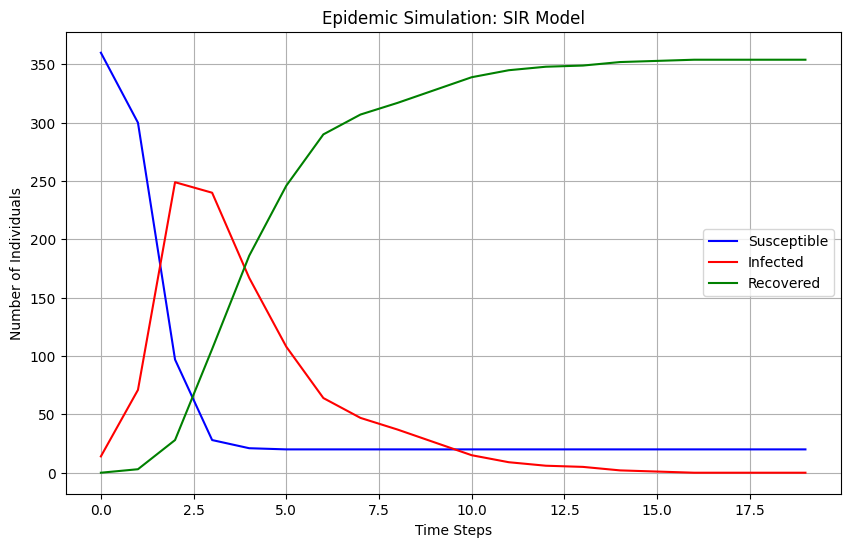

In [229]:
import matplotlib.pyplot as plt

def visualize_epidemic(trends):
    # Access the correct 'node_count' dictionary
    node_counts = trends['trends']['node_count']
    
    # Extract time series data for Susceptible (0), Infected (1), and Recovered (2)
    time_steps = range(len(node_counts[0]))  # Length of the time series
    susceptible = node_counts[0]  # 'S' count
    infected = node_counts[1]     # 'I' count
    recovered = node_counts.get(2, [0] * len(time_steps))  # 'R' count (ensure it's present)

    # Plot the epidemic trends over time
    plt.figure(figsize=(10, 6))
    plt.plot(time_steps, susceptible, label='Susceptible', color='blue')
    plt.plot(time_steps, infected, label='Infected', color='red')
    plt.plot(time_steps, recovered, label='Recovered', color='green')

    plt.xlabel('Time Steps')
    plt.ylabel('Number of Individuals')
    plt.title('Epidemic Simulation: SIR Model')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming you have run the run_epidemic function and stored the trends
trends = NetworkModels(g = G_cleaned).run_epidemic(20, 2, 1/3, 1/20, 0.04)[0]

# Visualize the trends
visualize_epidemic(trends)


In [223]:
trends = NetworkModels(g = G_cleaned).run_epidemic(200, 1, 1/3, 1/20, 0.04)
print(trends)

[{'trends': {'node_count': {0: [360, 290, 117, 28, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20], 1: [14, 79, 231, 241, 164, 108, 74, 48, 32, 22, 16, 14, 10, 6, 4, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,